In [1]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra

### Part 1: Get collocation points and integration kernel for whole domain

In [5]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 0.5 # unit: angstrom
xavg = 0.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V_{eq}(x)$ and $p_{eq}(x)$

In [112]:
Vref = symmetry_wall_potential.(-0.5, 0.5, 0.01, 2.4e9, xref)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

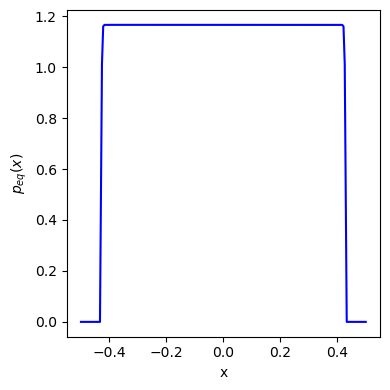

In [104]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4))
ax.plot(xref, rho_eq .* rho_eq, color="blue")
ax.set_xlabel("x")
ax.set_ylabel("\$ p_{eq}(x) \$")
plt.tight_layout()
plt.show()

### Part 3: Set the force constant($\sigma$ of Gaussian) of Photon Operator

In [105]:
## Photon Operator
k_photon = 5000. # unit: kcal/mol/angstrom^2
sigma_photon = 1 / sqrt(2 * k_photon);

### Part 4: Read Trajectory

#### physical parameters about simulations

In [106]:
save_freq = 1e-3 # unit: s, Save trajectory per 10e-3 s
total_times = 10 # unit: s, totol simulate 10 s
dt = 1e-5 # unit: s  # Integration Times 1ps
#kbT = 1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 100 timesteps. There will be 10000 data points.


#### read simulated trajectory from jld file

In [119]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/flat_potential_5.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
#rho_eq = load(f_in, "rho_eq")
D = load(f_in, "D");

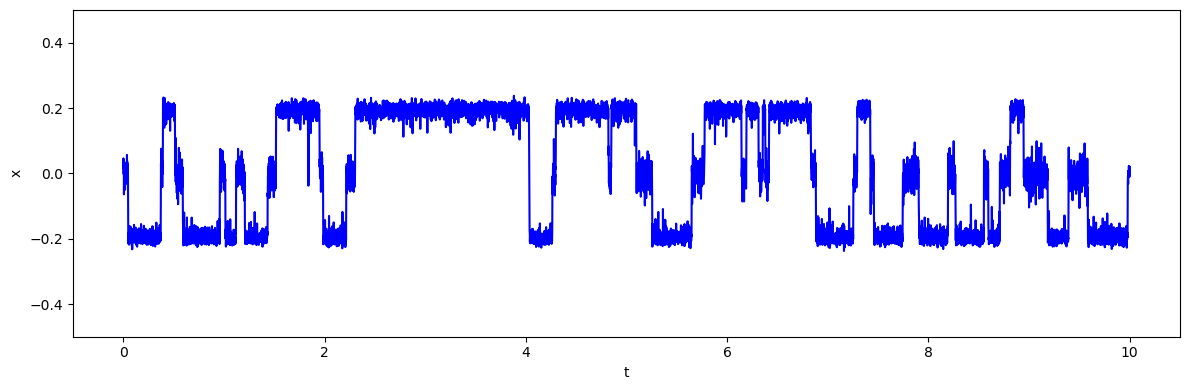

In [120]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))
ax.plot(t_record, y_record, color="blue")
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_ylim(-0.5, 0.5)
#ax.set_title("Model 1")
plt.tight_layout()
plt.show()

### Part 5: Log-likelihood test

In [121]:
p = p_eq
Nv = 72
D_answer = 1.
l_answer = get_loglikelihood(Nh, Np, xratio, xavg, p, D_answer, Nv, tau, y_record, save_freq, k_photon);

In [122]:
D_array = D_array = range(0.1, stop=3,length=30)
l_array = zeros(length(D_array))
idx = 1
for D_test in D_array
    l_array[idx] = get_loglikelihood(Nh, Np, xratio, xavg, p, D_test, Nv, tau, y_record, save_freq, k_photon)
    idx += 1
end

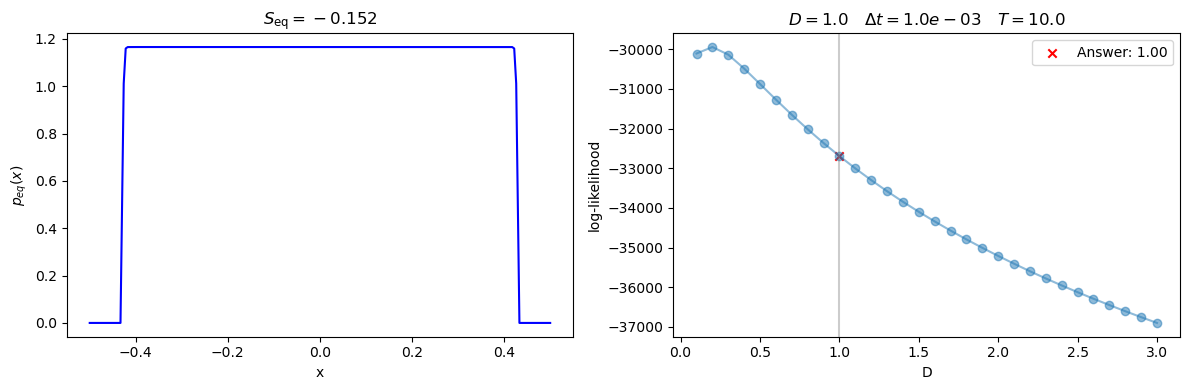

In [123]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax = axes[1]
ax.plot(xref, rho_eq .* rho_eq, color="blue")
ax.set_xlabel("x")
ax.set_ylabel("\$ p_{eq}(x) \$")
s_eq = -sum(w0 .* p_eq .* log.(p_eq))
ax.set_title(@sprintf "\$S_{\\rm eq}=%.3f\$" s_eq)

ax = axes[2]
ax.plot(D_array, l_array, "-o", alpha=0.5)
label = @sprintf "Answer: %.2f" D
ax.scatter(D_answer, l_answer, label=label, color="red", marker="x")
ax.set_ylabel("log-likelihood")
ax.set_xlabel("D")
ax.legend()
ax.axvline(1, color="grey", alpha=0.4)
title = @sprintf "\$ D=%.1f~~~\\Delta t=%.1e~~~T=%.1f~\$" D save_freq total_times
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/flat_D_l_scan_5.svg")
plt.show()